In [1]:
import collections
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numba to make things faster
import numba

# The MCMC Hammer
import emcee

# Numerical differentiation package
import numdifftools as ndt

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Estimating mean day-time and night-time inter-contraction times for each jellyfish

In [18]:
df_cauchy = pd.read_csv("df_cauchy.csv")


In [13]:
@numba.jit(nopython=True)

def log_posterior_cauchy(x, mu, beta):
    """
    JIT the hard part of the calculation for speed.
    """
    return -(len(x) + 1) * np.log(beta) \
                    - np.sum(np.log(1.0 + ((x - mu) / beta)**2))
        

def log_posterior(p, x, x_min=0, x_max=300):
    """
    Log posterior.  
    
    x = activity levels, but can be anything we measure repeatedly.
    
    p[0] = parameter we're estimating (mean mean activity in this case)
    p[1] = beta (Cauchy scale parameter)
    x_min = kind of obvious.
    x_max = 300s (based on the data)
    """
    
    # Unpack parameters
    mu, beta = p
    
    if (mu < x_min) or (mu > x_max) or (beta <= 0.0):
        return -np.inf
    
    return log_posterior_cauchy(x, mu, beta)

In [37]:
def cauchy_mcmc(data, n_dim=2, n_walkers=50, n_burn=1000, n_steps=5000, log_post = log_posterior):
    
    # Generate random starting points for walkers.  
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    p0[:,0] = np.random.uniform(0.0, 300.0, n_walkers)     # mu
    p0[:,1] = np.random.exponential(1.0, n_walkers)      # beta

    args = (data["IntTime"].values,)
    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, args=args)
    
    # Burn in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    
    # Run MCMC
    _ = sampler.run_mcmc(pos, n_steps)

    # Find MAPs
    max_ind = np.argmax(sampler.flatlnprobability)
    mu_MAP, beta_MAP = sampler.flatchain[max_ind,:]
    
    return mu_MAP, sampler.flatchain

In [43]:
mu_MAP_out, sampler_flatchain_out= cauchy_mcmc(df_cauchy[(df_cauchy["Jellyfish"]==1) & (df_cauchy["DayNight"]=='Day')])

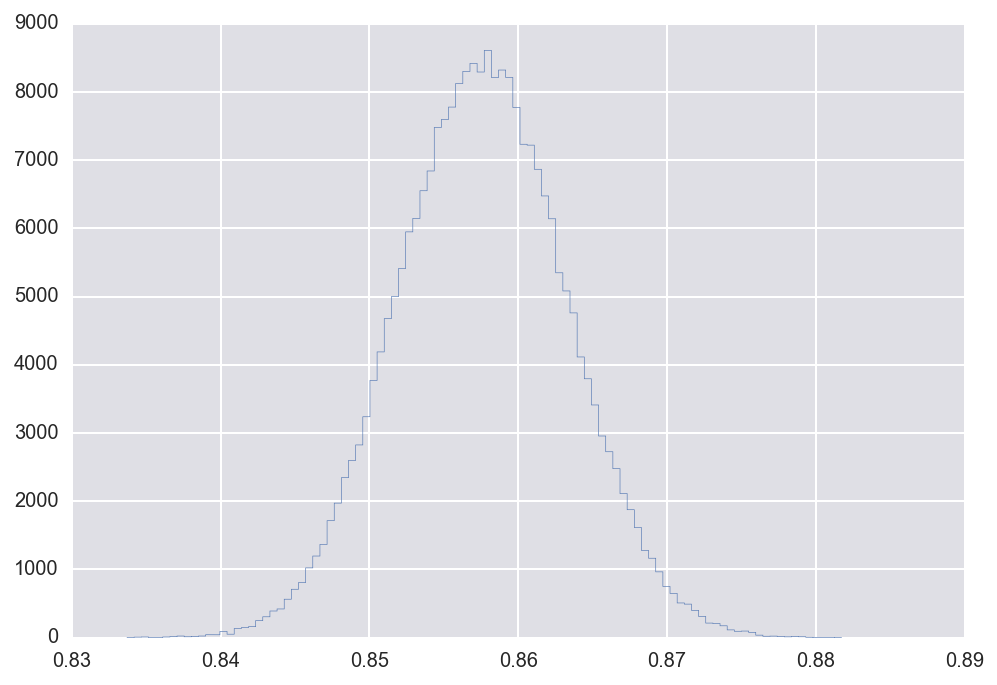

In [49]:
_=plt.hist(sampler_flatchain_out[:,0], histtype="step", bins=100)

In [35]:
ar = (v["IntTime"].values,)

In [60]:
def cauchy_mcmc(emcee_reqs, n_dim=2, n_walkers=50, 
                n_burn=1000, n_steps=5000, 
                log_post = log_posterior, mean_of_means=False):
    """
    emcee_reqs: if running MCMC on individual jellyfish, then df_cauchy, jellyfish number and time of day.
    if running MCMC for mean of means, just an array with mu_MAPs.
    """
    if not mean_of_means: 
        
        #unpack params
        df, jel_num, time_of_day = emcee_reqs
        
        data = df[(df["Jellyfish"]==jel_num)&(df["DayNight"]==time_of_day)]
        # Generate random starting points for walkers.  
        # p0[i,j] is the starting point for walk i along variable j.
        p0 = np.empty((n_walkers, n_dim))
        p0[:,0] = np.random.uniform(0.0, 300.0, n_walkers)     # mu
        p0[:,1] = np.random.exponential(1.0, n_walkers)      # beta

        args = (data["IntTime"].values,)
        # Set up the EnsembleSampler instance
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, args=args)

        # Burn in
        pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

        # Run MCMC
        _ = sampler.run_mcmc(pos, n_steps)

        # Find MAPs
        max_ind = np.argmax(sampler.flatlnprobability)
        mu_MAP, beta_MAP = sampler.flatchain[max_ind,:]

        return mu_MAP, sampler.flatchain
    
    else:
        
        data = emcee_reqs
        
        p0 = np.empty((n_walkers, n_dim))
        p0[:,0] = np.random.uniform(0.0, 300.0, n_walkers)     # mu
        p0[:,1] = np.random.exponential(1.0, n_walkers) 
        
        args = (data,)
        # Set up the EnsembleSampler instance
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, args=args)

        # Burn in
        pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

        # Run MCMC
        _ = sampler.run_mcmc(pos, n_steps)

        # Find MAPs
        max_ind = np.argmax(sampler.flatlnprobability)
        mean_of_means_MAP, beta_MAP = sampler.flatchain[max_ind,:]

        return mean_of_means_MAP, sampler.flatchain

In [63]:
params = [df_cauchy, 1, "Day"]
jel1_day_mu, jel1_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

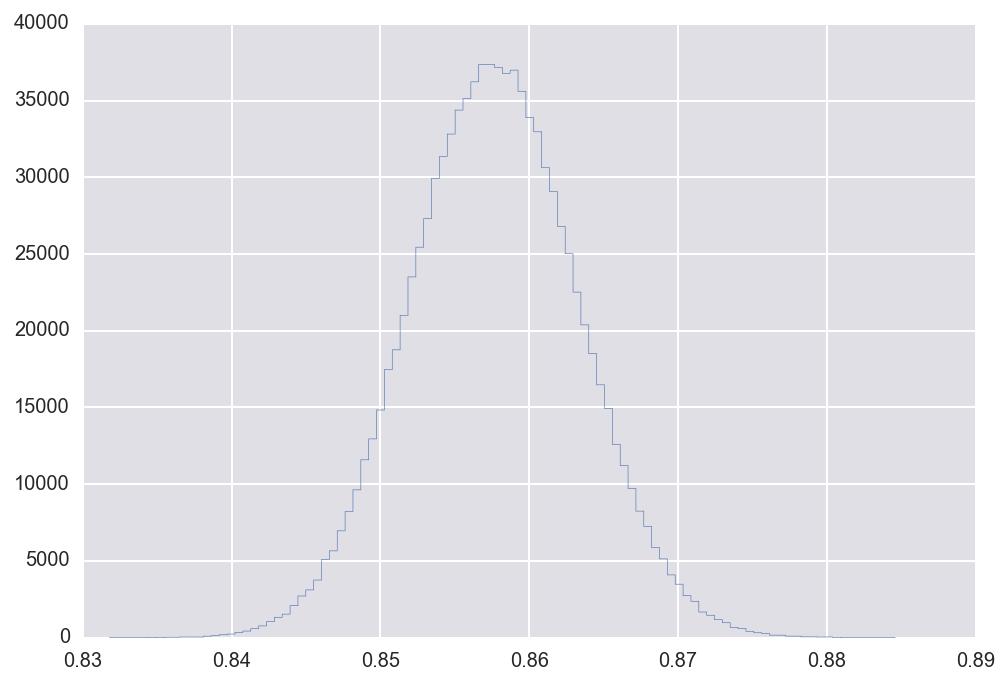

In [64]:
_=plt.hist(jel1_day_flat[:,0], histtype="step", bins=100)

In [65]:
params = [df_cauchy, 1, "Night"]
jel1_night_mu, jel1_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

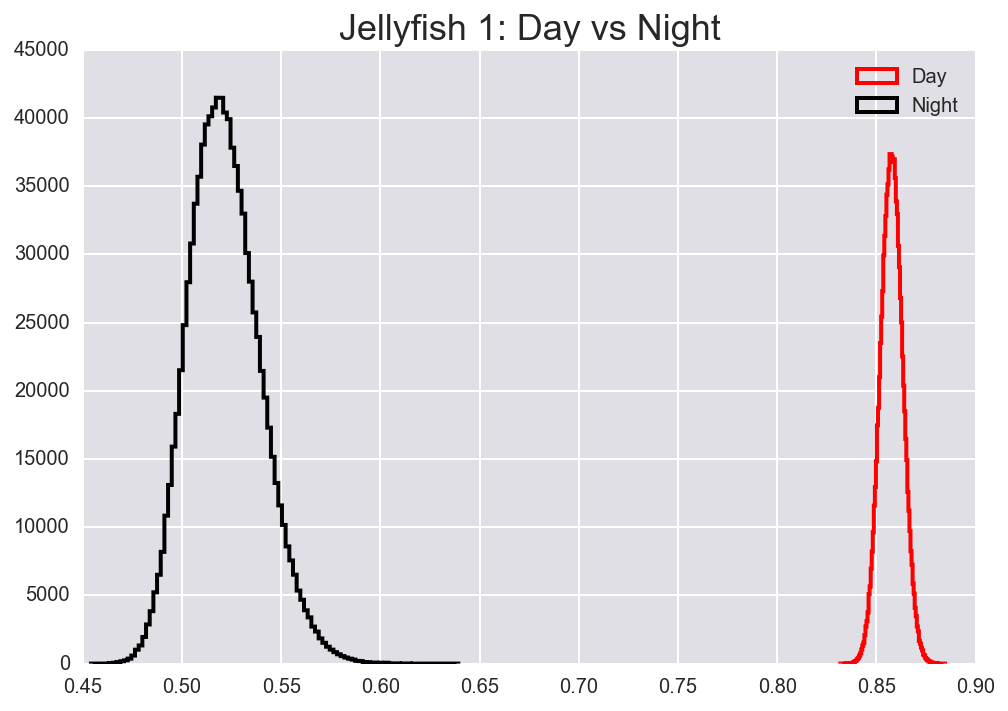

In [82]:
_=plt.hist(jel1_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel1_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 1: Day vs Night")

In [66]:
params = [df_cauchy, 2, "Day"]
jel2_day_mu, jel2_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

In [77]:
params = [df_cauchy, 2, "Night"]
jel2_night_mu, jel2_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

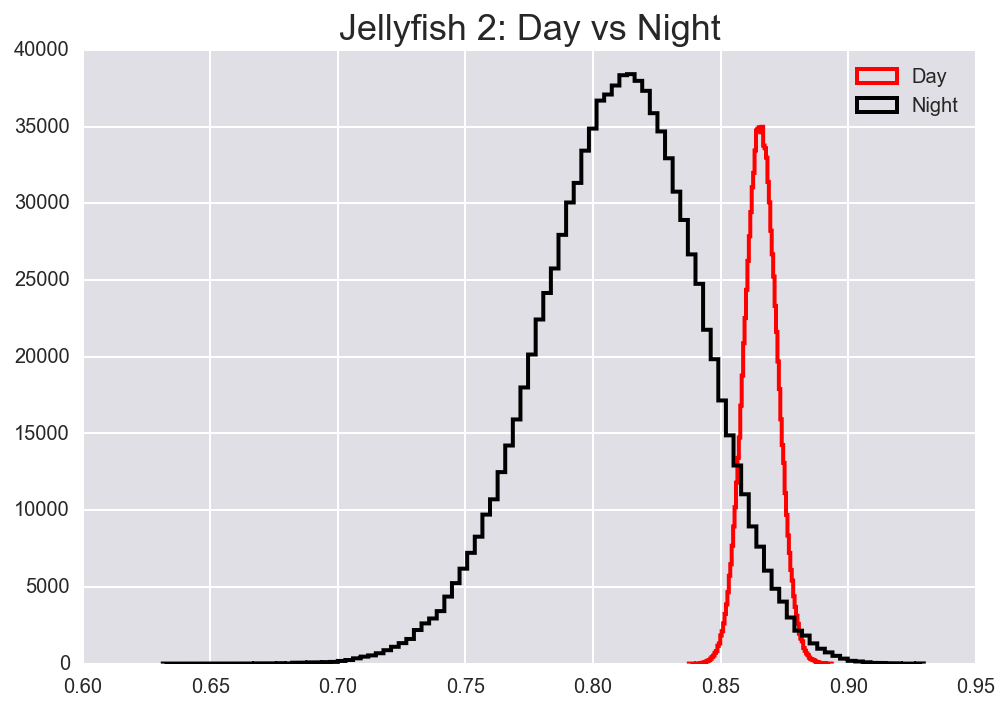

In [87]:
_=plt.hist(jel2_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel2_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 2: Day vs Night")

In [81]:
params = [df_cauchy, 3, "Day"]
jel3_day_mu, jel3_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)
params = [df_cauchy, 3, "Night"]
jel3_night_mu, jel3_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

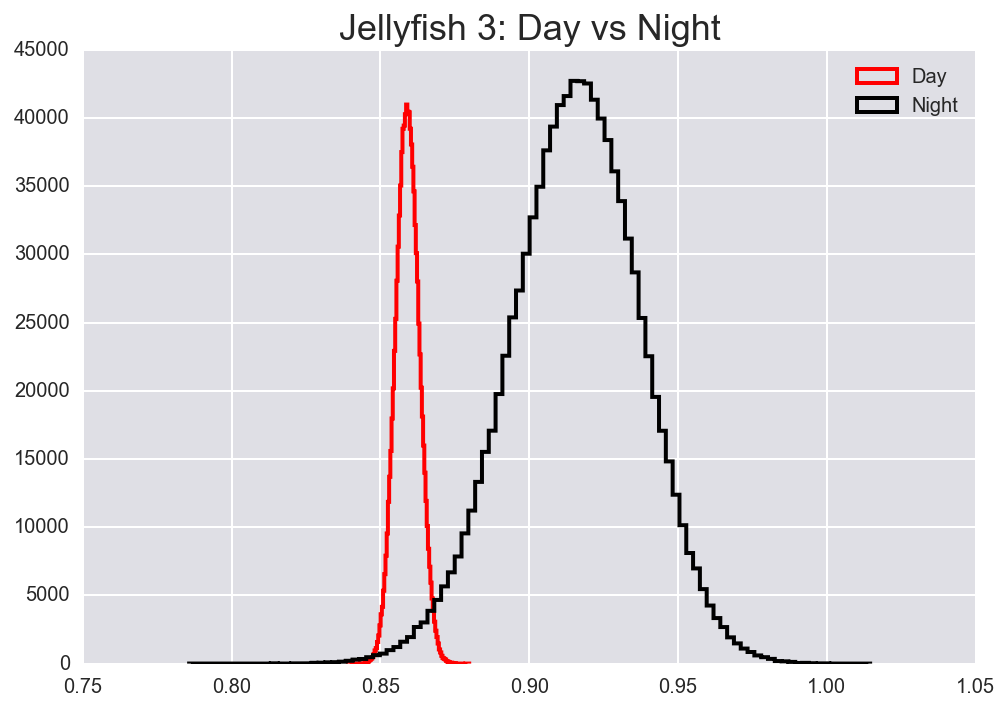

In [85]:
_=plt.hist(jel3_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel3_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 3: Day vs Night")

In [86]:
params = [df_cauchy, 4, "Day"]
jel4_day_mu, jel4_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)
params = [df_cauchy, 4, "Night"]
jel4_night_mu, jel4_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

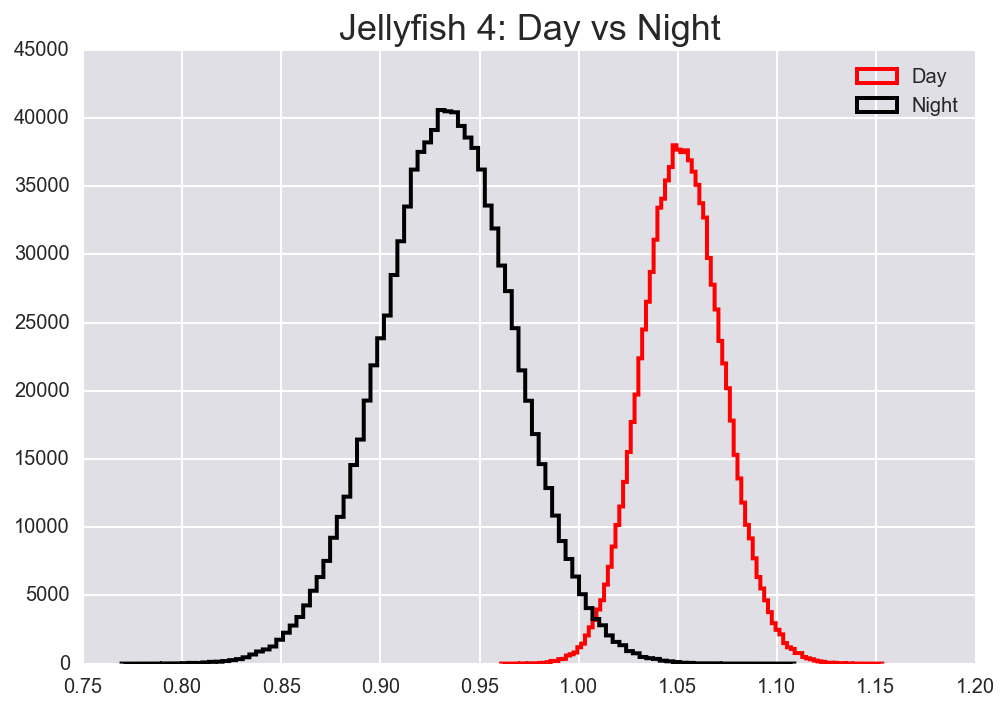

In [88]:
_=plt.hist(jel4_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel4_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 4: Day vs Night")

In [89]:
params = [df_cauchy, 5, "Day"]
jel5_day_mu, jel5_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)
params = [df_cauchy, 5, "Night"]
jel5_night_mu, jel5_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

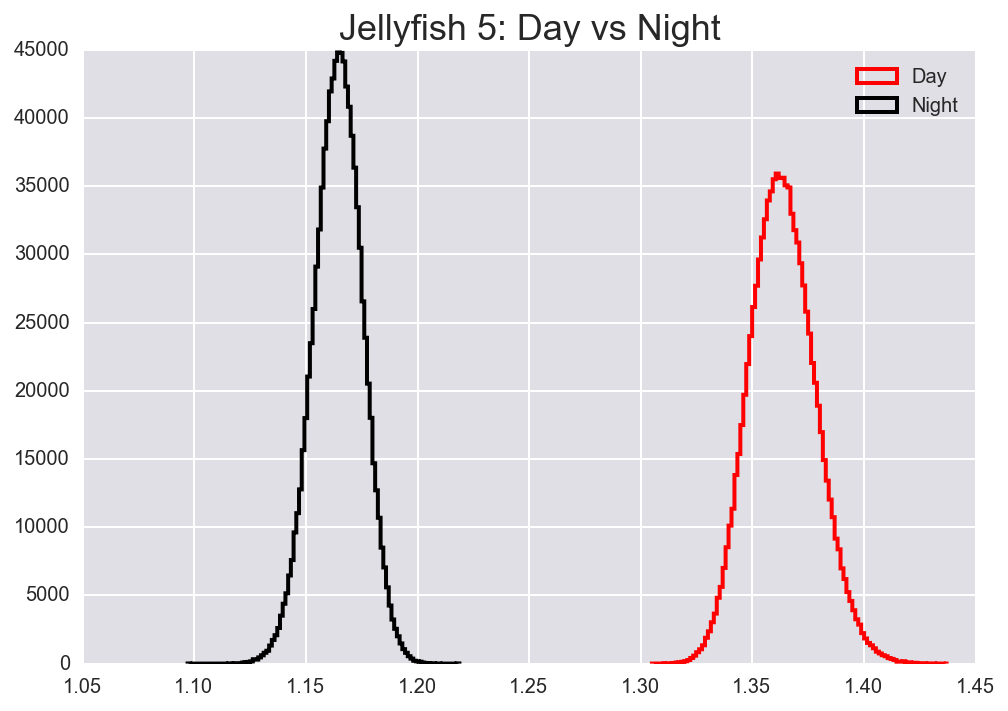

In [90]:
_=plt.hist(jel5_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel5_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 5: Day vs Night")

In [91]:
params = [df_cauchy, 6, "Day"]
jel6_day_mu, jel6_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)
params = [df_cauchy, 6, "Night"]
jel6_night_mu, jel6_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

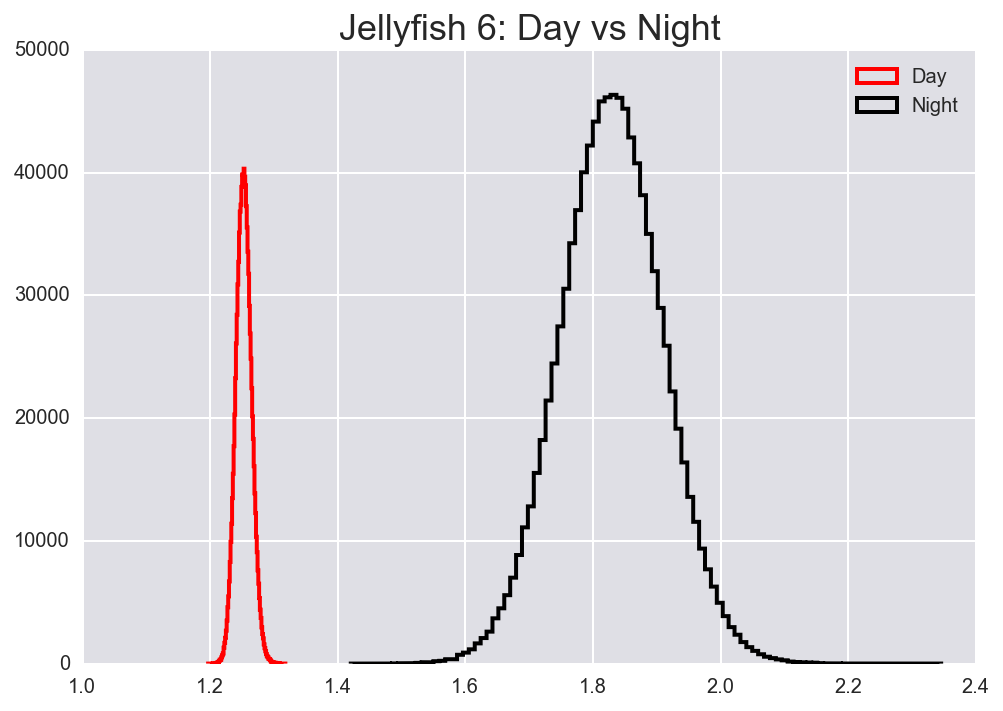

In [93]:
_=plt.hist(jel6_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel6_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 6: Day vs Night")

In [94]:
params = [df_cauchy, 7, "Day"]
jel7_day_mu, jel7_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)
params = [df_cauchy, 7, "Night"]
jel7_night_mu, jel7_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

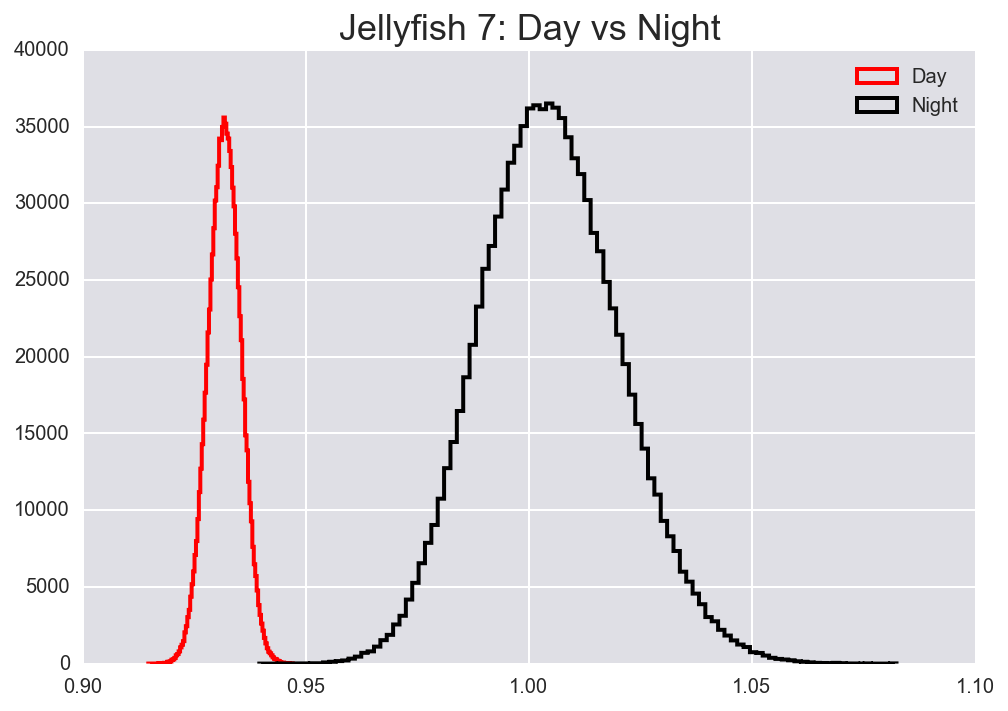

In [95]:
_=plt.hist(jel7_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel7_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 7: Day vs Night")

In [96]:
params = [df_cauchy, 8, "Day"]
jel8_day_mu, jel8_day_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)
params = [df_cauchy, 8, "Night"]
jel8_night_mu, jel8_night_flat = cauchy_mcmc(params, 
                                         n_dim=2, 
                                         n_walkers=100, 
                                         n_burn=1000, 
                                         n_steps=10000, 
                                         log_post = log_posterior)

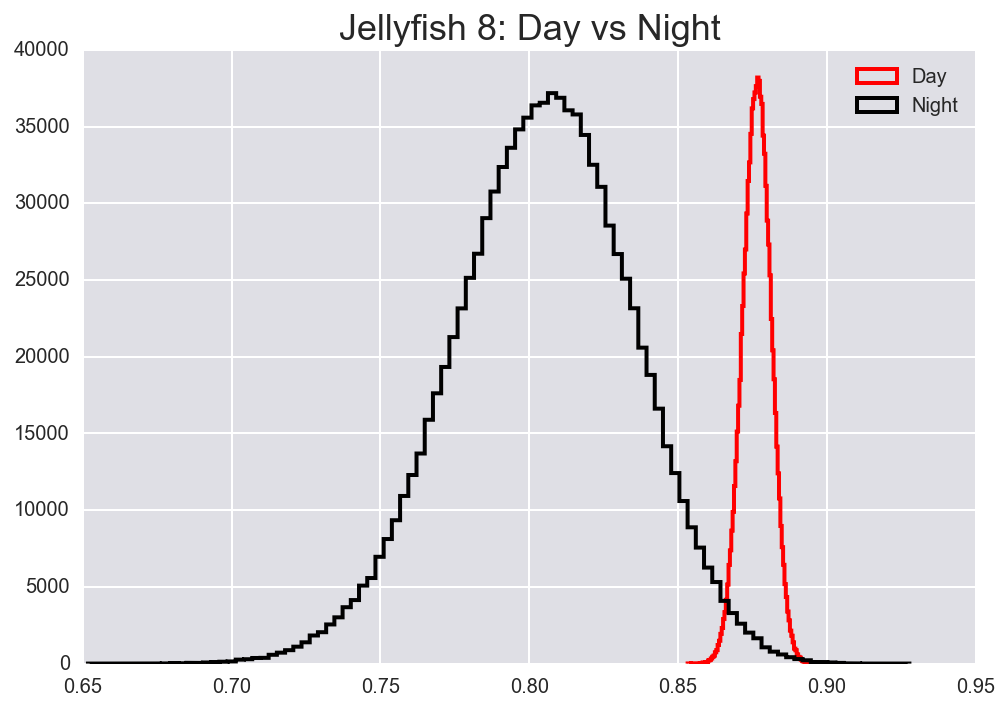

In [97]:
_=plt.hist(jel8_day_flat[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(jel8_night_flat[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Jellyfish 8: Day vs Night")

In [101]:
day_means = np.array((jel1_day_mu, 
                     jel2_day_mu, 
                     jel3_day_mu, 
                     jel4_day_mu, 
                     jel5_day_mu, 
                     jel6_day_mu, 
                     jel7_day_mu, 
                     jel8_day_mu))
night_means = np.array((jel1_night_mu, 
                     jel2_night_mu, 
                     jel3_night_mu, 
                     jel4_night_mu, 
                     jel5_night_mu, 
                     jel6_night_mu, 
                     jel7_night_mu, 
                     jel8_night_mu))

In [102]:
night_means

array([ 0.51841272,  0.81314076,  0.91686284,  0.93464748,  1.16494203,
        1.82664964,  1.00325123,  0.80679595])

In [105]:
mean_of_means_MAP_day, sampler_MOM_day =  cauchy_mcmc(day_means, n_dim=2, n_walkers=100, 
                n_burn=1000, n_steps=10000, 
                log_post = log_posterior, mean_of_means=True)

In [104]:
mean_of_means_MAP_night, sampler_MOM_night =  cauchy_mcmc(night_means, n_dim=2, n_walkers=100, 
                n_burn=1000, n_steps=10000, 
                log_post = log_posterior, mean_of_means=True)

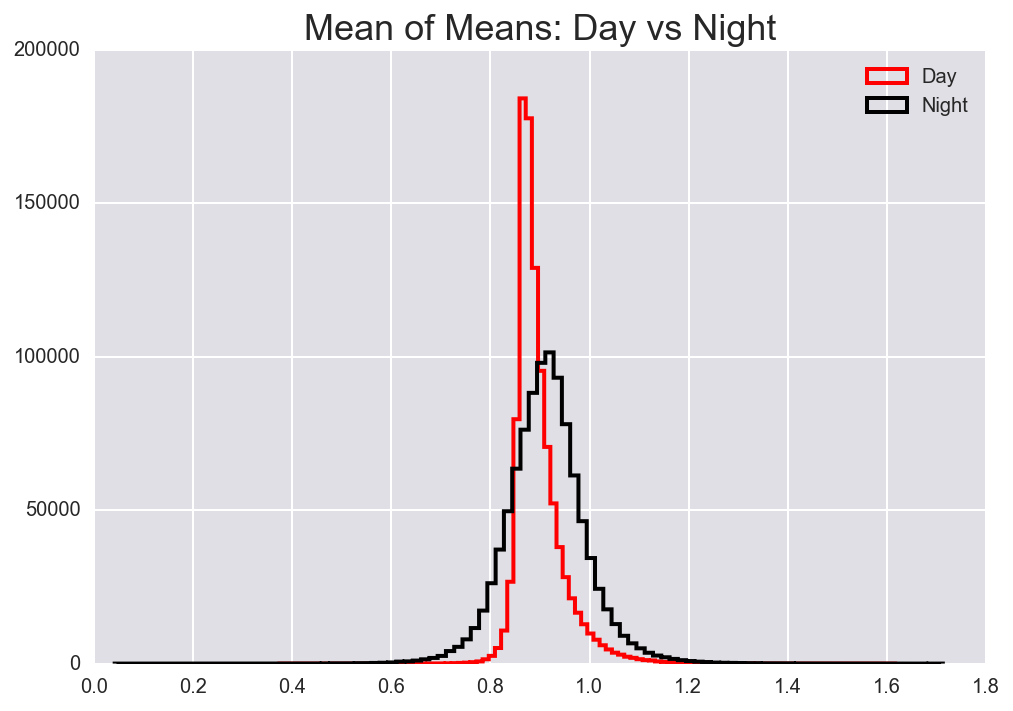

In [106]:
_=plt.hist(sampler_MOM_day[:,0], histtype="step", bins=100, color="red", lw=2)
_=plt.hist(sampler_MOM_night[:,0], histtype="step", bins=100, color="black", lw=2)
plt.legend(labels=["Day", "Night"])
plt.title("Mean of Means: Day vs Night")